In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from xgboost import XGBClassifier

In [13]:
df = pd.read_csv("./creditcard.csv")

In [14]:
print(df.shape)
print(df.columns)
print(df["Class"].value_counts())

(284807, 31)
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')
Class
0    284315
1       492
Name: count, dtype: int64


In [15]:
df.isnull().sum()
print(df.duplicated().sum())
df = df.drop_duplicates()
print(df.duplicated().sum())

1081
0


In [16]:
scaler = StandardScaler()
df["normAmount"] = scaler.fit_transform(df[["Amount"]])
df["normTime"] = scaler.fit_transform(df[["Time"]])

df.drop(["Amount", "Time"], axis=1, inplace=True)

In [17]:
fraud = df[df["Class"] == 1]
non_fraud = df[df["Class"] == 0].sample(n=len(fraud), random_state=42)
print(len(fraud))
balanced_df = pd.concat([fraud, non_fraud])
balanced_df = balanced_df.sample(frac=1, random_state=42)

473


In [18]:
X = balanced_df.drop("Class", axis=1)
y = balanced_df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(y)
print(balanced_df.columns.get_loc("Class"))

154697    1
8842      1
91708     0
233258    1
17317     1
         ..
41395     1
144108    1
36725     0
249239    1
33276     1
Name: Class, Length: 946, dtype: int64
28


In [19]:
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    tree_method="hist",
    eval_metric="logloss",
)
xgb.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


[[93  2]
 [ 6 89]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96        95
           1       0.98      0.94      0.96        95

    accuracy                           0.96       190
   macro avg       0.96      0.96      0.96       190
weighted avg       0.96      0.96      0.96       190

ROC AUC: 0.9869252077562327


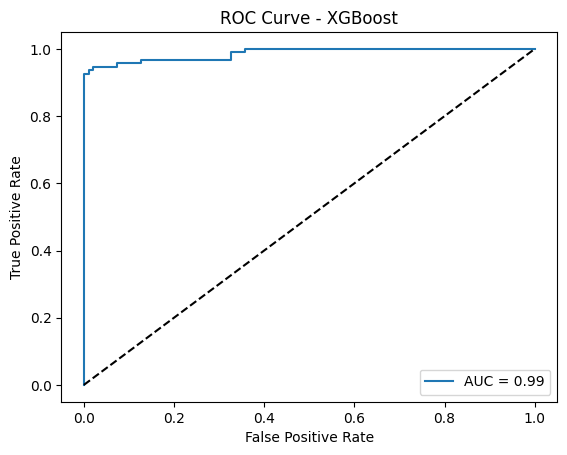

In [20]:
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

auc = roc_auc_score(y_test, y_prob)
print("ROC AUC:", auc)

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.show()

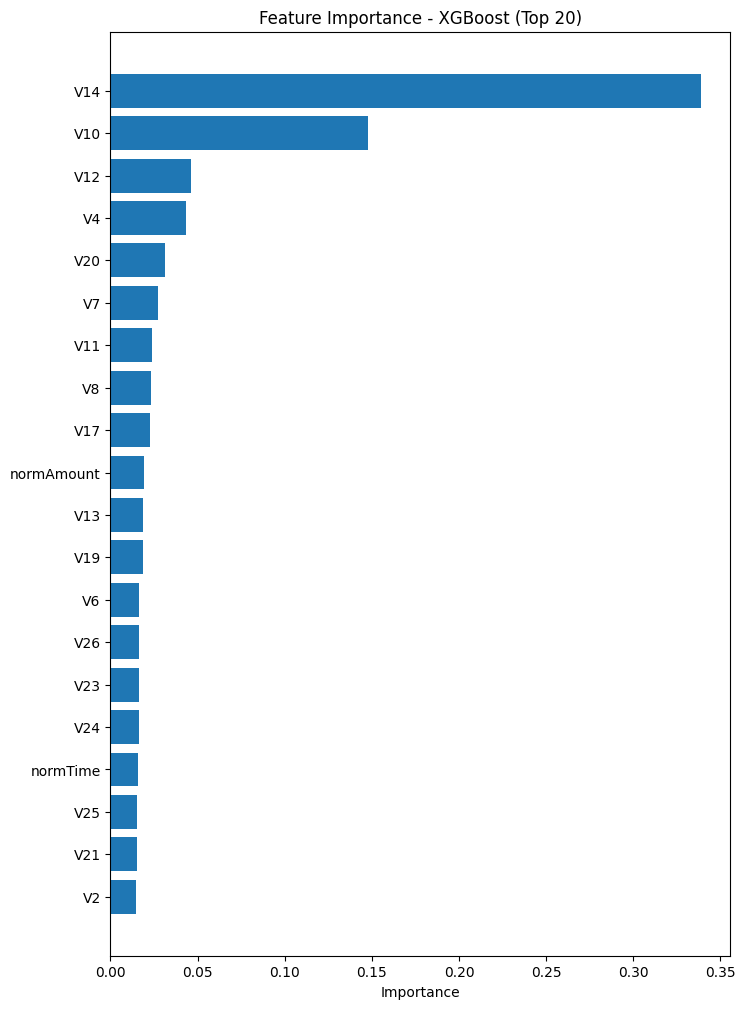

In [21]:
importances = xgb.feature_importances_
features = X.columns

indices = np.argsort(importances)

plt.figure(figsize=(8, 12))
plt.barh(np.array(features)[indices][-20:], importances[indices][-20:])
plt.xlabel("Importance")
plt.title("Feature Importance - XGBoost (Top 20)")
plt.show()

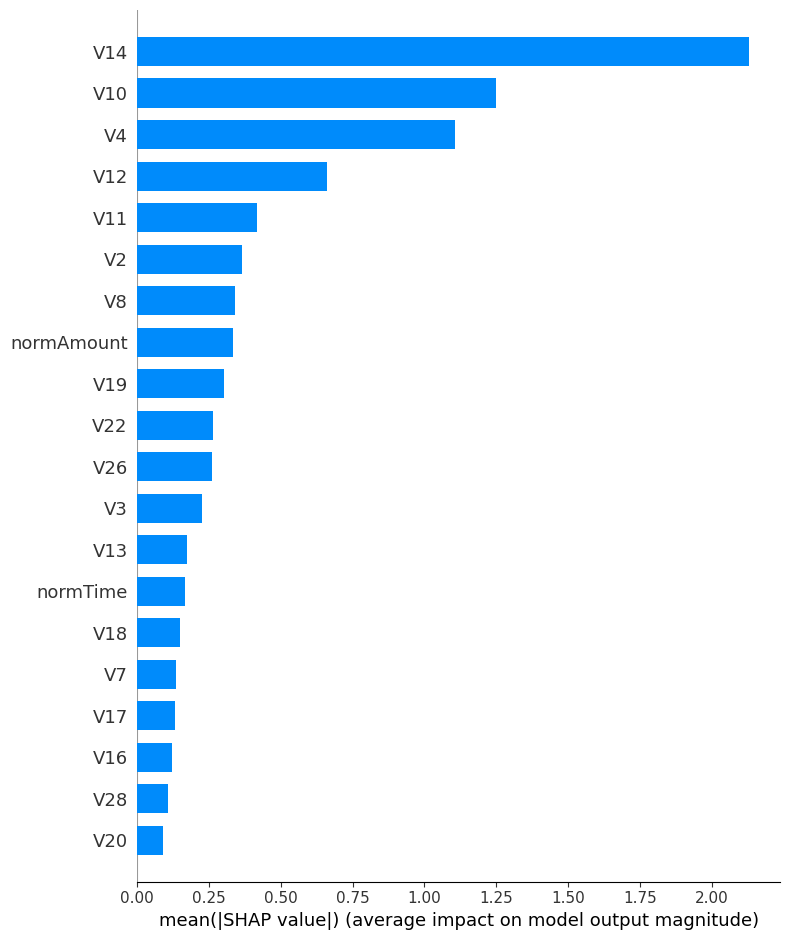

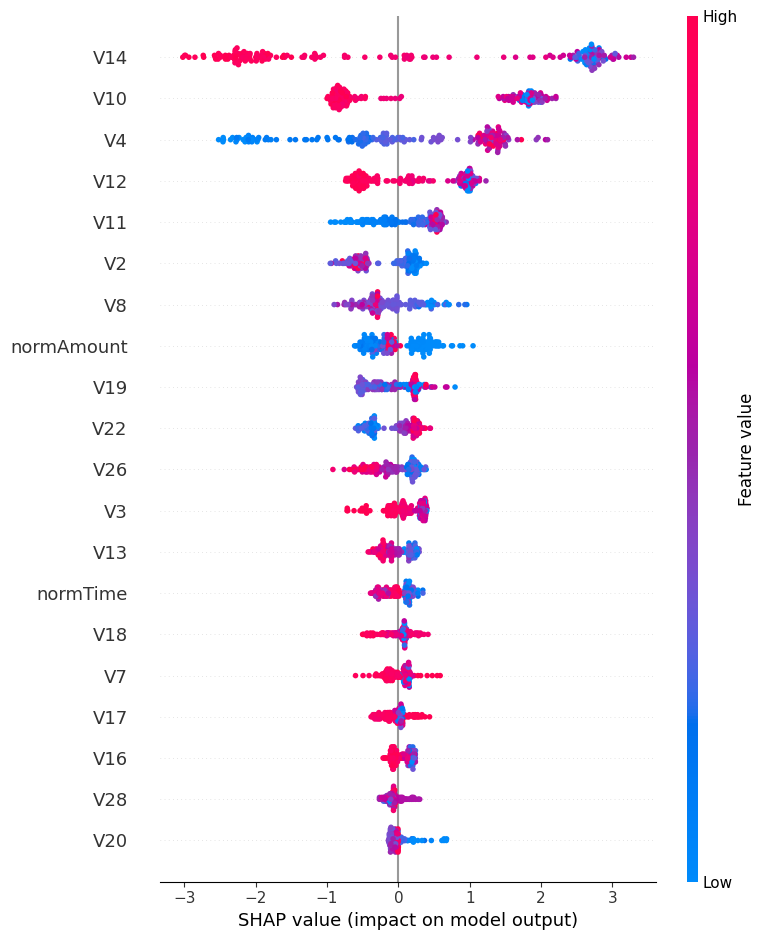

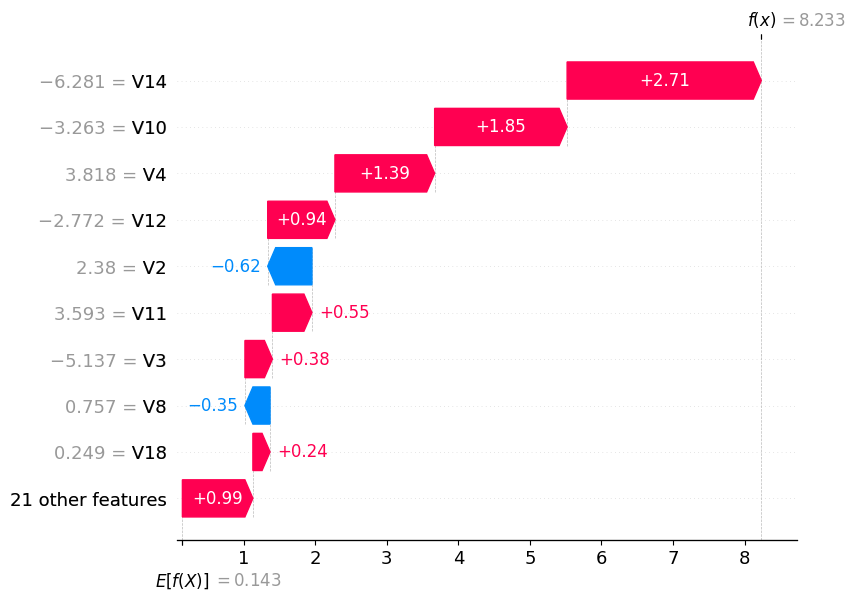

In [22]:
import shap

# TreeExplainer 適合樹模型
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)

# 單筆交易解釋
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[0],
        base_values=explainer.expected_value,
        data=X_test.iloc[0],
        feature_names=X_test.columns,
    )
)

In [23]:
# ===============================
# 第二版：不重抽樣 + scale_pos_weight
# ===============================

# 使用完整資料
X_full = df.drop(columns=["Class"])
y_full = df["Class"]

num_pos = int((y_full == 1).sum())
num_neg = int((y_full == 0).sum())
spw = num_neg / num_pos
print("scale_pos_weight =", spw)

# 與第一版相同的切分方式
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_full, y_full, test_size=0.2, stratify=y_full, random_state=42
)

xgb2 = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    tree_method="hist",
    scale_pos_weight=spw,
    eval_metric=["auc", "aucpr", "logloss"],
)

xgb2.fit(X_train2, y_train2)

scale_pos_weight = 598.8435517970402


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,"['auc', 'aucpr', ...]"


[[56605    46]
 [   17    78]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.63      0.82      0.71        95

    accuracy                           1.00     56746
   macro avg       0.81      0.91      0.86     56746
weighted avg       1.00      1.00      1.00     56746

ROC AUC: 0.9724449514989748


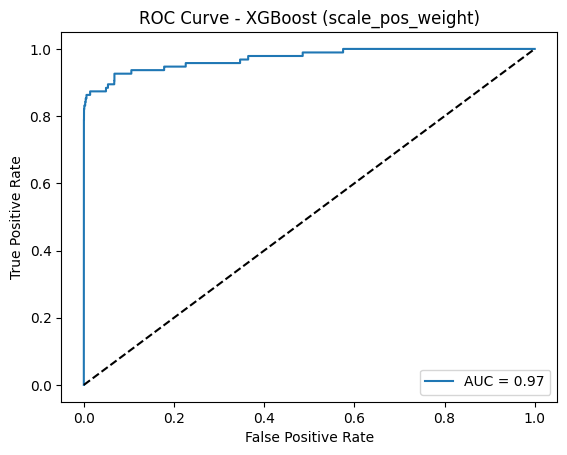

best threshold by F1: 0.9617527
[[56648     3]
 [   23    72]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.96      0.76      0.85        95

    accuracy                           1.00     56746
   macro avg       0.98      0.88      0.92     56746
weighted avg       1.00      1.00      1.00     56746



In [24]:
# 評估：混淆矩陣、分類報告、ROC 與 AUC
from sklearn.metrics import precision_recall_curve

y_pred2 = xgb2.predict(X_test2)
y_prob2 = xgb2.predict_proba(X_test2)[:, 1]

print(confusion_matrix(y_test2, y_pred2))
print(classification_report(y_test2, y_pred2))

aur2 = roc_auc_score(y_test2, y_prob2)
print("ROC AUC:", aur2)

fpr2, tpr2, thresholds2 = roc_curve(y_test2, y_prob2)
plt.plot(fpr2, tpr2, label=f"AUC = {aur2:.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost (scale_pos_weight)")
plt.legend()
plt.show()

# 可選：找 F1 最佳閾值
prec, rec, th = precision_recall_curve(y_test2, y_prob2)
f1 = 2 * prec * rec / (prec + rec + 1e-9)
best_idx = np.argmax(f1)
best_th = th[best_idx] if best_idx < len(th) else 0.5
print("best threshold by F1:", best_th)

y_pred_best = (y_prob2 >= best_th).astype(int)
print(confusion_matrix(y_test2, y_pred_best))
print(classification_report(y_test2, y_pred_best))

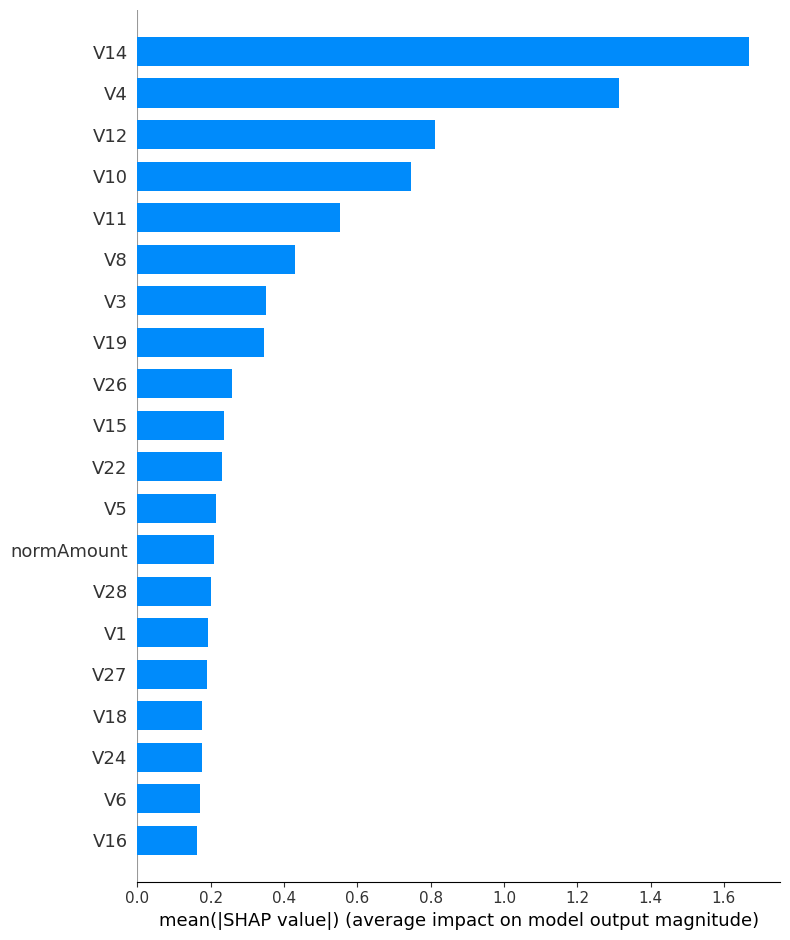

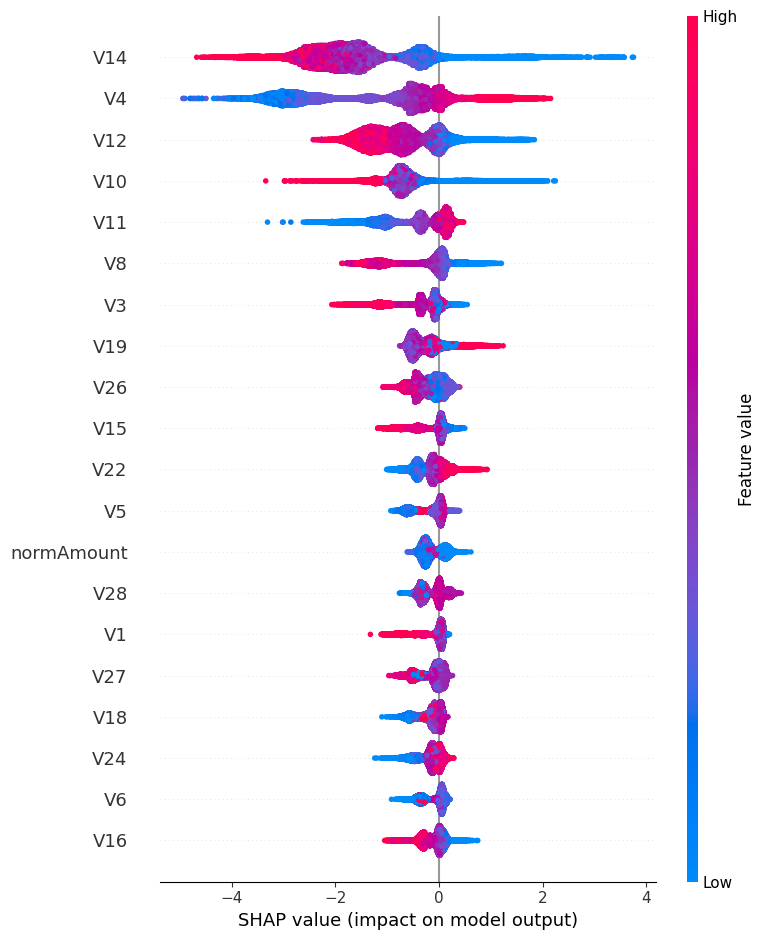

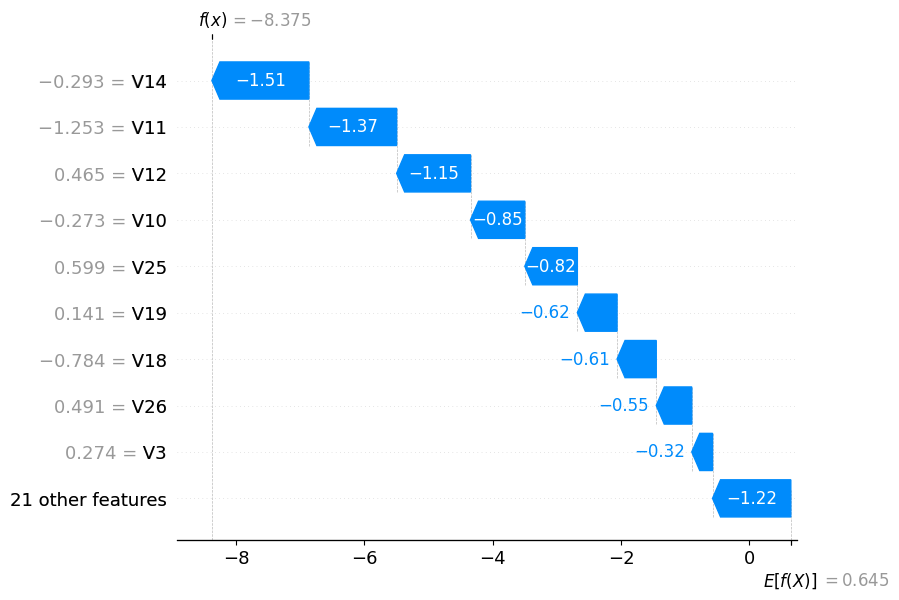

In [25]:
# 第二版：SHAP（完整資料版本）
explainer2 = shap.TreeExplainer(xgb2)
shap_values2 = explainer2.shap_values(X_test2)

shap.summary_plot(shap_values2, X_test2, plot_type="bar")
shap.summary_plot(shap_values2, X_test2)

shap.plots.waterfall(
    shap.Explanation(
        values=shap_values2[0],
        base_values=explainer2.expected_value,
        data=X_test2.iloc[0],
        feature_names=X_test2.columns,
    )
)

In [26]:
# 兩版本對照表：v1(重抽樣) vs v2(scale_pos_weight)
from sklearn.metrics import average_precision_score

# v1 指標（使用前面 y_test, y_pred, y_prob）
metrics_v1 = {
    "AUC": roc_auc_score(y_test, y_prob),
    "AP": average_precision_score(y_test, y_prob),
    "Accuracy": (y_pred == y_test).mean(),
}

# v2 指標（使用 y_test2, y_pred2, y_prob2）
metrics_v2 = {
    "AUC": roc_auc_score(y_test2, y_prob2),
    "AP": average_precision_score(y_test2, y_prob2),
    "Accuracy": (y_pred2 == y_test2).mean(),
}

comparison = pd.DataFrame([metrics_v1, metrics_v2], index=["v1_resample", "v2_spw"])
print(comparison)

# 加上 v2 的最佳 F1 閾值版本
from sklearn.metrics import precision_recall_fscore_support

precision2, recall2, f1_2, _ = precision_recall_fscore_support(
    y_test2, y_pred_best, average="binary", zero_division=0
)
print(
    {
        "v2_bestF1_precision": precision2,
        "v2_bestF1_recall": recall2,
        "v2_bestF1_f1": f1_2,
        "v2_bestF1_threshold": best_th,
    }
)

                  AUC        AP  Accuracy
v1_resample  0.986925  0.989671  0.957895
v2_spw       0.972445  0.815705  0.998890
{'v2_bestF1_precision': 0.96, 'v2_bestF1_recall': 0.7578947368421053, 'v2_bestF1_f1': 0.8470588235294118, 'v2_bestF1_threshold': np.float32(0.9617527)}


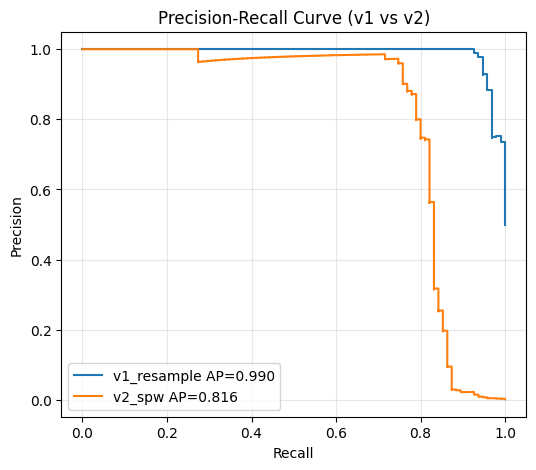

In [27]:
# PR 曲線（v1: 重抽樣, v2: scale_pos_weight）
from sklearn.metrics import precision_recall_curve, average_precision_score

# v1
prec1, rec1, _ = precision_recall_curve(y_test, y_prob)
ap1 = average_precision_score(y_test, y_prob)

# v2
prec2, rec2, _ = precision_recall_curve(y_test2, y_prob2)
ap2 = average_precision_score(y_test2, y_prob2)

plt.figure(figsize=(6, 5))
plt.step(rec1, prec1, where="post", label=f"v1_resample AP={ap1:.3f}")
plt.step(rec2, prec2, where="post", label=f"v2_spw AP={ap2:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (v1 vs v2)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

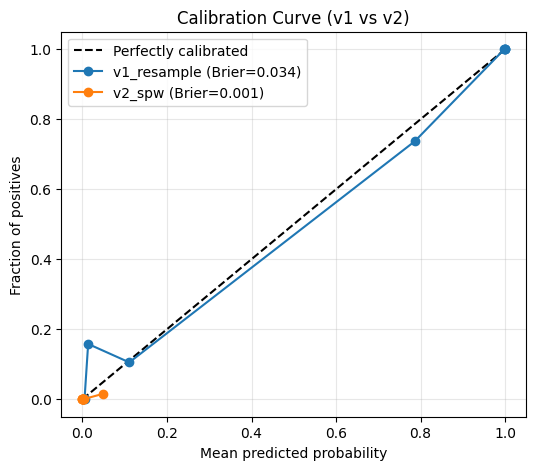

In [28]:
# 校準曲線與 Brier 分數（v1 vs v2）
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

# v1
prob_true1, prob_pred1 = calibration_curve(
    y_test, y_prob, n_bins=10, strategy="quantile"
)
brier1 = brier_score_loss(y_test, y_prob)

# v2
prob_true2, prob_pred2 = calibration_curve(
    y_test2, y_prob2, n_bins=10, strategy="quantile"
)
brier2 = brier_score_loss(y_test2, y_prob2)

plt.figure(figsize=(6, 5))
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.plot(prob_pred1, prob_true1, marker="o", label=f"v1_resample (Brier={brier1:.3f})")
plt.plot(prob_pred2, prob_true2, marker="o", label=f"v2_spw (Brier={brier2:.3f})")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve (v1 vs v2)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [29]:
# 多閾值對照表（v1 與 v2）
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
)

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
rows = []
for th in thresholds:
    # v1
    y_pred1_th = (y_prob >= th).astype(int)
    rows.append(
        {
            "model": "v1_resample",
            "threshold": th,
            "precision": precision_score(y_test, y_pred1_th, zero_division=0),
            "recall": recall_score(y_test, y_pred1_th, zero_division=0),
            "f1": f1_score(y_test, y_pred1_th, zero_division=0),
        }
    )
    # v2
    y_pred2_th = (y_prob2 >= th).astype(int)
    rows.append(
        {
            "model": "v2_spw",
            "threshold": th,
            "precision": precision_score(y_test2, y_pred2_th, zero_division=0),
            "recall": recall_score(y_test2, y_pred2_th, zero_division=0),
            "f1": f1_score(y_test2, y_pred2_th, zero_division=0),
        }
    )

th_table = pd.DataFrame(rows)
th_table

,model,threshold,precision,recall,f1
0,v1_resample,0.1,0.892157,0.957895,0.923858
1,v2_spw,0.1,0.179431,0.863158,0.297101
2,v1_resample,0.2,0.919192,0.957895,0.938144
3,v2_spw,0.2,0.316206,0.842105,0.459770
4,v1_resample,0.3,0.937500,0.947368,0.942408
5,v2_spw,0.3,0.451429,0.831579,0.585185
6,v1_resample,0.4,0.967742,0.947368,0.957447
7,v2_spw,0.4,0.552448,0.831579,0.663866
8,v1_resample,0.5,0.978022,0.936842,0.956989
9,v2_spw,0.5,0.629032,0.821053,0.712329
